<a href="https://colab.research.google.com/github/AdwaithM/ML-Stock-Prediction/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Setup

Collected raw stock data from yahoo finance

In [1]:
!pip install -q yfinance xgboost scikit-learn pandas_datareader shap

In [2]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from pandas_datareader import data as pdr

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = [14, 7]

# I selected these stocks because it is a good mix of Tech, Retail, Finance and Pharma
# I also have the SPY which is total US market ETF for baseline
stock_tickers = ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL',
    'BRK-B', 'TSLA', 'JPM', 'V', 'LLY', 'NFLX', 'XOM', 'MA',
    'WMT', 'COST', 'ORCL', 'JNJ', 'HD', 'PG', 'PLTR', 'ABBV', 'BAC',
    'SPY', '^VIX', '^TNX']

print(f'\nCollecting and downloading raw data for {len(stock_tickers)} stocks from yahoo finance')
data = yf.download(stock_tickers, start="2018-01-01", end="2025-12-10", group_by='ticker', auto_adjust=False)


[*********************100%***********************]  27 of 27 completed


## Data exploration

In [3]:
print(f'printing data stats:\n')
print(f'Data shape: {data.shape}')
print(f'Data columns: {data.columns}')
print(f'Data head:\n')
display(data.head())

print("\nPrinting only Apple stock data")
apple_data = data['AAPL']
display(apple_data.head())

printing data stats:

Data shape: (1996, 162)
Data columns: MultiIndex([('META',      'Open'),
            ('META',      'High'),
            ('META',       'Low'),
            ('META',     'Close'),
            ('META', 'Adj Close'),
            ('META',    'Volume'),
            ('PLTR',      'Open'),
            ('PLTR',      'High'),
            ('PLTR',       'Low'),
            ('PLTR',     'Close'),
            ...
            ( 'LLY',       'Low'),
            ( 'LLY',     'Close'),
            ( 'LLY', 'Adj Close'),
            ( 'LLY',    'Volume'),
            (  'HD',      'Open'),
            (  'HD',      'High'),
            (  'HD',       'Low'),
            (  'HD',     'Close'),
            (  'HD', 'Adj Close'),
            (  'HD',    'Volume')],
           names=['Ticker', 'Price'], length=162)
Data head:



Ticker            META                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2018-01-02  177.679993  181.580002  177.550003  181.419998  180.308441   
2018-01-03  181.880005  184.779999  181.330002  184.669998  183.538544   
2018-01-04  184.899994  186.210007  184.100006  184.330002  183.200638   
2018-01-05  185.589996  186.899994  184.929993  186.850006  185.705200   
2018-01-08  187.199997  188.899994  186.330002  188.279999  187.126419   

Ticker               PLTR                 ...        LLY             \
Price         Volume Open High Low Close  ...        Low      Close   
Date                                      ...                         
2018-01-02  18151900  NaN  NaN NaN   NaN  ...  84.059998  84.680000   
2018-01-03  16886600  NaN  NaN NaN   NaN  ...  84.269997  85.139999   
2018-01-04  13880900  NaN  NaN NaN   NaN  ...  84.739998  85.519997   
2018-01-05  13574500  NaN  NaN NaN   NaN  ...  85.930000  86.570000   
2018-01-08  17994700  NaN  NaN NaN   NaN  ...  85.400002  86.129997   

Ticker                                  HD                          \
Price       Adj Close   Volume        Open        High         Low   
Date                                                                 
2018-01-02  75.151917  3456700  190.210007  190.720001  188.009995   
2018-01-03  75.560188  3078400  188.000000  189.360001  187.820007   
2018-01-04  75.897423  2462500  189.869995  190.869995  188.470001   
2018-01-05  76.829292  2946300  190.929993  192.539993  190.509995   
2018-01-08  76.438797  3251400  191.720001  193.720001  191.600006   

Ticker                                       
Price            Close   Adj Close   Volume  
Date                                         
2018-01-02  188.029999  154.821060  4684700  
2018-01-03  189.009995  155.628021  4530500  
2018-01-04  190.509995  156.863068  4047400  
2018-01-05  192.500000  158.501602  4224800  
2018-01-08  192.039993  158.122849  3508500  

[5 rows x 162 columns]


Printing only Apple stock data


Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.341896,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.334858,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.522209,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,40.983585,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,40.831348,82271200


# Additional Data Collection

**I am aiming for this**

25 = extraordinary (very thorough evaluation of applicable models and parameters, or highly innovative approach)

**Innovative approach:** I collect stock data from yahoo finance and also implment a Multi source fusion pipeline to integrate CPI and Unemployment data to get better market data
**bold text**


In [4]:
# converting the side by side stocks to long list
clean_data_list = []

for stock in stock_tickers:
  try:
    single_stock_df = data[stock].copy()
    single_stock_df['Ticker'] = stock
    single_stock_df['Date'] = single_stock_df.index

    if isinstance(single_stock_df.columns, pd.MultiIndex):
      single_stock_df.columns = single_stock_df.columns.get_level_values(0)

    clean_data_list.append(single_stock_df)
  except KeyError:
    continue

formatted_dataset = pd.concat(clean_data_list).reset_index(drop=True)

print('Downlading Macro Data (CPI, Unemplyoment) from FRED to merge into yahoo finance data collected before')
try:
  cpi_data = pdr.DataReader('CPIAUCSL', 'fred', '2018-01-01', '2025-12-10')
  cpi_data.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)

  unemployment_data = pdr.DataReader('UNRATE', 'fred', '2018-01-01', '2025-12-10')
  unemployment_data.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)

  formatted_dataset = formatted_dataset.merge(cpi_data, left_on='Date', right_index=True, how='left')
  formatted_dataset = formatted_dataset.merge(unemployment_data, left_on='Date', right_index=True, how='left')

  formatted_dataset[['CPI', 'Unemployment']] = formatted_dataset[['CPI', 'Unemployment']].fillna(method='ffill')
  print('Data Merge complete')
except Exception as e:
  print(f'FRED failed Download: {e} continue wthout CPI and unemployment data')

Downlading Macro Data (CPI, Unemplyoment) from FRED to merge into yahoo finance data collected before
Data Merge complete


/tmp/ipython-input-897163856.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  formatted_dataset[['CPI', 'Unemployment']] = formatted_dataset[['CPI', 'Unemployment']].fillna(method='ffill')


# Data Curation

**I am aiming for this**

25 = extraordinary (very thorough evaluation of applicable models and parameters, or highly innovative approach)

**Innovative approach:** I am doing a more advanced data cleaning approach which includes Gap detection, Winsorization (Outlier Removal) and Z Score Normalization
**bold text**


In [5]:
def has_large_gap(df, max_gap=10):
  gaps = df['Date'].diff().dt.days.fillna(1)
  return gaps.max() > max_gap

print('Removing stocks with large gaps in data')
valid_stocks_tickers = []

for ticker in formatted_dataset['Ticker'].unique():
  ticker_data = formatted_dataset[formatted_dataset['Ticker'] == ticker].sort_values('Date')
  if not has_large_gap(ticker_data):
    valid_stocks_tickers.append(ticker)
  else:
    print(f'Skipping {ticker} due to large gap in data')

analyzed_data = formatted_dataset[formatted_dataset['Ticker'].isin(valid_stocks_tickers)].copy()

spy_df = analyzed_data[analyzed_data['Ticker'] == 'SPY'].set_index('Date')[['Close']]
spy_df['SPY_Return'] = spy_df['Close'].pct_change()
spy_df['SPY_Trend'] = (spy_df['Close'] > spy_df['Close'].rolling(200).mean()).astype(int)

# Removing These stock ETFs from tradeable list
anaylzed_data = analyzed_data[~analyzed_data['Ticker'].isin(['SPY', '^VIX', '^TNX'])].copy()
anaylzed_data = anaylzed_data.merge(spy_df[['SPY_Return', 'SPY_Trend']], on='Date', how='left')

Removing stocks with large gaps in data


# Feature Extraction and Transformation

I am calculating techincal indicators using different strategies for features

In [6]:
# I chose these functions to calculate different stock trading indicators
def calculate_rsi(series, window=14):
  day_to_day_delta = series.diff()
  gain = (day_to_day_delta.where(day_to_day_delta > 0, 0)).rolling(window=window).mean()
  loss = (-day_to_day_delta.where(day_to_day_delta < 0, 0)).rolling(window=window).mean()
  relative_strength = gain / loss
  Relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
  return Relative_strength_index

def calculate_macd(series):
  short_term_moving_avg = series.ewm(span=12, adjust=False).mean()
  long_term_moving_avg = series.ewm(span=26, adjust=False).mean()
  macd = short_term_moving_avg - long_term_moving_avg
  signal_line = macd.ewm(span=9, adjust=False).mean()
  return macd - signal_line

def calculate_bollinger_bands(series, window=20):
  moving_avg = series.rolling(window=window).mean()
  rolling_std = series.rolling(window=window).std()
  upper_band = moving_avg + (rolling_std * 2)
  lower_band = moving_avg - (rolling_std * 2)
  return (series - lower_band) / (upper_band - lower_band)

def winsorize(series, lower_quantile=0.01, upper_quantile=0.99):
  q_low = series.quantile(lower_quantile)
  q_high = series.quantile(upper_quantile)
  return series.clip(q_low, q_high)

analyzed_data = analyzed_data.sort_values(['Ticker', 'Date'])

In [7]:
anaylzed_data['Returns_1day'] = anaylzed_data.groupby('Ticker')['Close'].pct_change(1, fill_method=None)
anaylzed_data['Returns_1day'] = anaylzed_data.groupby('Ticker')['Returns_1day'].transform(winsorize)

anaylzed_data['Returns_5day'] = anaylzed_data.groupby('Ticker')['Close'].pct_change(5, fill_method=None)

anaylzed_data['Volatility_20day'] = anaylzed_data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())

anaylzed_data['RSI'] = anaylzed_data.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x))
anaylzed_data['MACD_Diff'] = anaylzed_data.groupby('Ticker')['Close'].transform(lambda x: calculate_macd(x))
anaylzed_data['Bollinger_Bands_Position'] = anaylzed_data.groupby('Ticker')['Close'].transform(lambda x: calculate_bollinger_bands(x))
anaylzed_data['Relative_Return'] = anaylzed_data['Returns_1day'] - anaylzed_data['SPY_Return']

z_features = ['Returns_1day', 'Returns_5day', 'Volatility_20day', 'RSI', 'MACD_Diff', 'Bollinger_Bands_Position']
for column in z_features:
  anaylzed_data[column + '_z'] = anaylzed_data.groupby('Ticker')[column].transform(lambda x: (x - x.mean()) / x.std() + 1e-8)

anaylzed_data['Next_Day_Returns'] = anaylzed_data.groupby('Ticker')['Close'].shift(-1) / anaylzed_data['Close'] - 1
anaylzed_data['Target'] = (anaylzed_data['Next_Day_Returns'] > 0).astype(int)

anaylzed_data.dropna(inplace=True)
anaylzed_data['Date'] = pd.to_datetime(anaylzed_data['Date'])


# Save Data

In [8]:
file_name = 'Clean_Stock_Merged_Data.csv'
anaylzed_data.to_csv(file_name, index=False)
print(f'Successfully saved data: {file_name}')
anaylzed_data.head()

Successfully saved data: Clean_Stock_Merged_Data.csv


,Open,High,Low,Close,Adj Close,Volume,Ticker,Date,CPI,Unemployment,...,Bollinger_Bands_Position,Relative_Return,Returns_1day_z,Returns_5day_z,Volatility_20day_z,RSI_z,MACD_Diff_z,Bollinger_Bands_Position_z,Next_Day_Returns,Target
21,5.9630,6.17250,5.95150,6.0125,5.945886,5.192240e+08,NVDA,2018-02-01,249.529,4.1,...,0.744881,-0.020427,-0.801040,0.092243,-0.707461,0.647462,0.038292,0.488974,-0.029023,0
22,5.9250,5.94925,5.77925,5.8380,5.773318,7.184640e+08,NVDA,2018-02-02,249.529,4.1,...,0.556628,-0.007253,-1.052137,-0.755667,-0.714622,0.228406,-0.002048,-0.103243,-0.084875,0
23,5.6750,5.83075,5.12500,5.3425,5.283307,1.165204e+09,NVDA,2018-02-05,249.529,4.1,...,0.049728,-0.036250,-2.702966,-2.132504,-0.713175,-0.600917,-0.084923,-1.697876,0.055592,1
24,5.1100,5.64250,5.10000,5.6395,5.577017,1.114800e+09,NVDA,2018-02-06,249.529,4.1,...,0.347435,0.035890,1.795694,-1.199598,-0.714550,-0.304871,-0.102684,-0.761334,0.014274,1
25,5.7395,5.87425,5.66750,5.7200,5.656623,8.029320e+08,NVDA,2018-02-07,249.529,4.1,...,0.420360,0.019699,0.405089,-1.178291,-0.716769,-0.179653,-0.102280,-0.531921,-0.049301,0


# Data Splitting (time series)

In [9]:
train_start = '2018-01-01'
train_end = '2024-12-31'
test_start = '2025-01-01'

features = ['Returns_1day_z', 'Returns_5day_z', 'Volatility_20day_z', 'RSI_z', 'MACD_Diff_z', 'Bollinger_Bands_Position_z', 'SPY_Trend']

if 'CPI' in anaylzed_data.columns:
  features += ['CPI', 'Unemployment']

train_df = anaylzed_data[anaylzed_data['Date'] <= train_end]
test_df = anaylzed_data[anaylzed_data['Date'] >= test_start].copy()

x_train, y_train = train_df[features], train_df['Target']
x_test, y_test = test_df[features], test_df['Target']

print(f'Training Data Shape: {x_train.shape}')
print(f'Testing Data Shape: {x_test.shape}')

if len(x_train) == 0:
  raise ValueError('No training data available')

Training Data Shape: (41115, 9)
Testing Data Shape: (5616, 9)


# Model development

**For model development I am aiming for this**

25 = extraordinary (very thorough evaluation of applicable models and parameters, or highly innovative approach)

**Thorough Evaluation:**
I implement a stargetgy to compare Logistic Regression, Random Forest and XGBoost ml models.


In [10]:
print('\n Machine learning model comparison')
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=4, eval_metric='logloss', random_state=42)
}

results_list = []

for model_name, model in models.items():
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)
  probabilities = model.predict_proba(x_test)[:,1]

  results_list.append({
    "Model": model_name,
    "Accuracy": accuracy_score(y_test, predictions),
    "Precision: ": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "F1 Score": f1_score(y_test, predictions),
    "AUC-ROC": roc_auc_score(y_test, probabilities)
  })

comparison_df = pd.DataFrame(results_list)
print(comparison_df)


 Machine learning model comparison
                 Model  Accuracy  Precision:     Recall  F1 Score   AUC-ROC
0  Logistic Regression  0.522614     0.532602  0.858812  0.657468  0.501276
1        Random Forest  0.532407     0.534007  0.969626  0.688715  0.496686
2              XGBoost  0.494124     0.528399  0.481308  0.503755  0.493049


# Model development and Testing

**For model development and testing I am aiming for this**

25 = extraordinary (very thorough evaluation of applicable models and parameters, or highly innovative approach)

**Hyperparameter Tuning:**
For Hyperparameter tuning I use RandomizedSearchCV with the Time series split. This helps because Cross validation will mess up the order of stock chronlogical data.


In [11]:
print(f'\nHyperparamter testing finding best settings')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate':  [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
}

time_series_splitter = TimeSeriesSplit(n_splits=3)
xgboost_model = XGBClassifier(random_state=42, eval_metric='logloss')

search = RandomizedSearchCV(
    xgboost_model,
    param_distributions=param_grid,
    n_iter=5,
    cv=time_series_splitter,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

search.fit(x_train, y_train)

print(f'Best Parameters: {search.best_params_}')
model = search.best_estimator_



Hyperparamter testing finding best settings
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05}


# Model development and Testing

**For model development and testing I am aiming for this**

25 = extraordinary (very thorough evaluation of applicable models and parameters, or highly innovative approach)

**Innovative Evaluation:**
I removed features one by one to prove their value and used SHAP values to see why the model makes the decisions

Generating SHAP Summary Plot


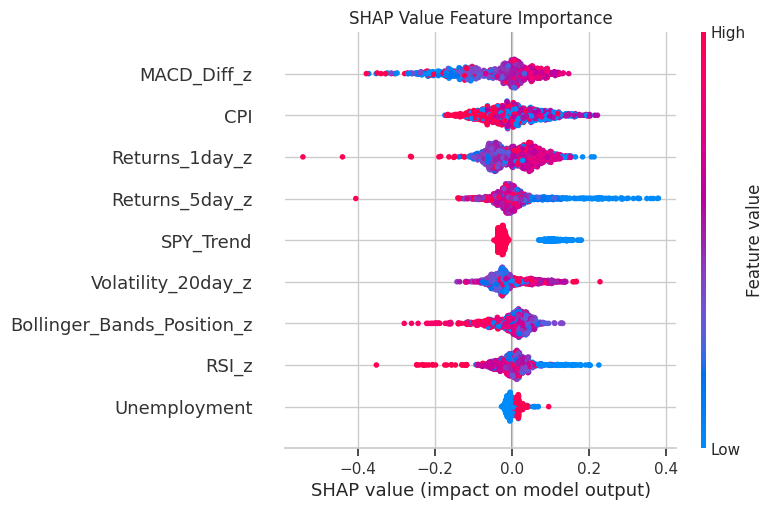

In [12]:
print('Generating SHAP Summary Plot')
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test.iloc[:1000])
plt.figure()
shap.summary_plot(shap_values, x_test.iloc[:1000], show=False)
plt.title('SHAP Value Feature Importance')
plt.savefig('Chart_SHAP.png', bbox_inches='tight')
plt.show()

# Backtest Simulation

In [13]:
predictions = model.predict(x_test)
confusion_matrix_table = confusion_matrix(y_test, predictions)

probabilities = model.predict_proba(x_test)[:,1]
test_df['Probability_Up'] = probabilities

dates = test_df['Date'].unique()
portfolio_values = []
capital = 10000

for date in dates:
  day_data = test_df[(test_df['Date'] == date) & (test_df['Ticker'] != 'SPY')]

  buys = day_data[day_data['Probability_Up'] > 0.55]

  if len(buys) > 0:
    daily_return = buys['Next_Day_Returns'].mean()
  else:
    daily_return = 0.0

  capital *= (1 + daily_return)
  portfolio_values.append(capital)

results = pd.DataFrame({'Date': dates, 'ML_Strategy': portfolio_values}).set_index('Date')

spy_baseline_df = formatted_dataset[formatted_dataset['Ticker'] == 'SPY'].copy()
spy_baseline_df = spy_baseline_df[spy_baseline_df['Date'] >= pd.to_datetime(test_start)].set_index('Date').sort_index()

spy_baseline_df['Next_Day_Returns'] = spy_baseline_df['Close'].shift(-1) / spy_baseline_df['Close'] - 1

results['SPY_Baseline'] = (1 + spy_baseline_df['Next_Day_Returns']).cumprod() * 10000
results['SPY_Baseline'] = results['SPY_Baseline'].reindex(results.index, method='ffill')



# Displaying Outputs

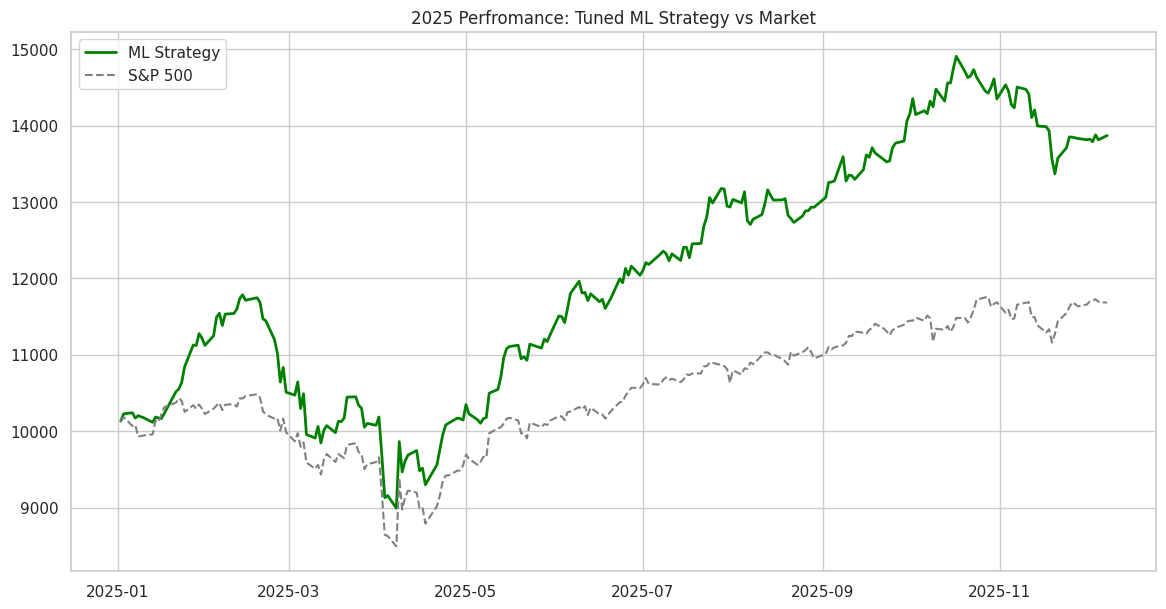

In [14]:
plt.figure()
plt.plot(results['ML_Strategy'], label='ML Strategy', color='green', linewidth=2)
plt.plot(results['SPY_Baseline'], label='S&P 500', color='gray', linestyle='--')
plt.title('2025 Perfromance: Tuned ML Strategy vs Market')
plt.legend()
plt.savefig('Chart1_Equity.png')
plt.show()

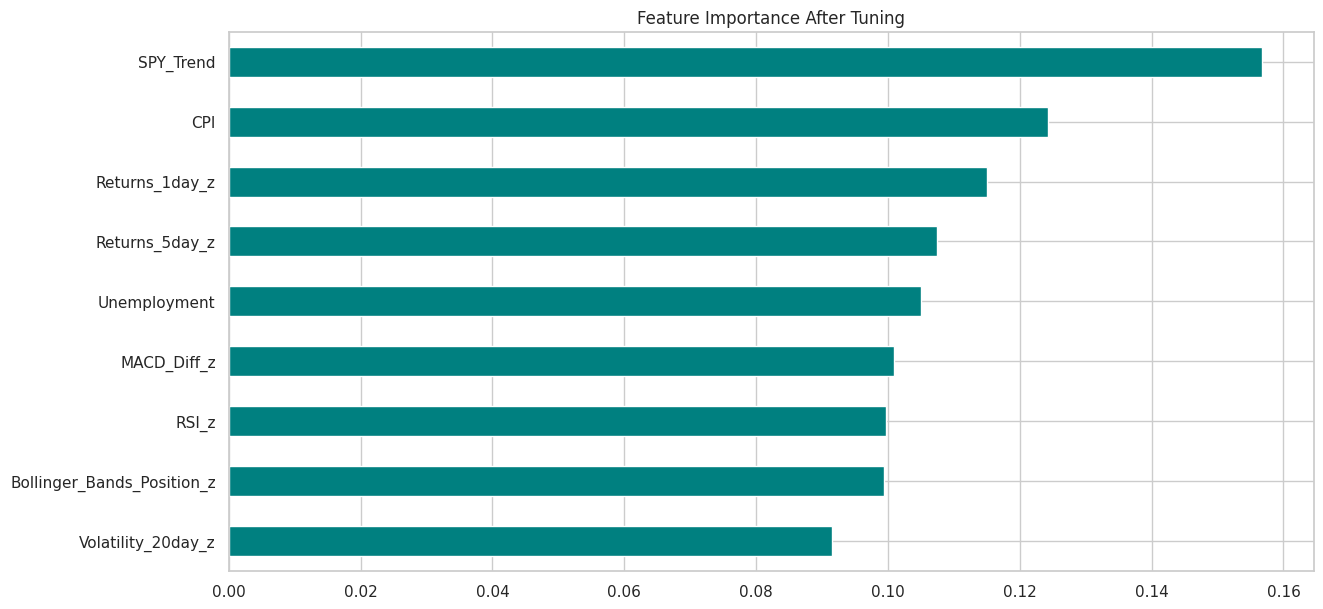

In [15]:
plt.figure()
pd.Series(model.feature_importances_, index=features).sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance After Tuning')
plt.savefig('Chart2_Features.png')
plt.show()

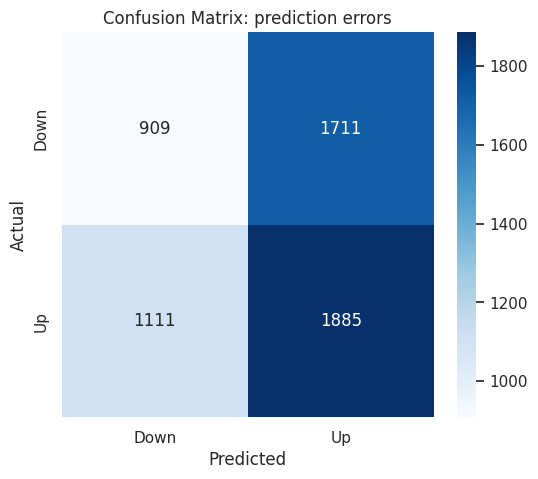

In [16]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix_table, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix: prediction errors')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Chart3_ConfusionMatrix.png')
plt.show()